## **Boosting Marketing Efficiency: Targeted Bank Campaign by Customer Subscription Behavior**

**Objective:** Develop a data-driven marketing strategy that maximizes return on investment (ROI) by identifying optimal trade-off between broad customer outreach and precision marketing using predictive modeling.

### **Data Load**

Simple data load and brief checks on missing values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = '../data/bank.csv'
df = pd.read_csv(file_path, sep=';')

**Data Overview**

To achieve our objective, we will be using the "Bank Marketing" dataset, which contains information from direct marketing campaigns of a Portuguese banking institution. The campaigns were conducted via phone calls to see if clients would subscribe to a term deposit.

The specific file used is 'bank.csv,' which includes 4,521 clients records. This is a 10% randomly selected sample from the full dataset, making it suitable for computationally intensive modeling techniques.

Key Characteristics:
- **Observations:** 4,521 clients
- **Attributes:** 17 total (16 input variables and 1 output variable)

The variables can be grouped into three primary categories:
- **Client data** (age, marital status, financial status, job, etc.)
- **Current campaign data** (contact type, call duration, etc.)
- **Historical data** (contact history, previous outcome, etc.)

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
print("--- Data Types and Missing Values ---\n")
df.info()

--- Data Types and Missing Values ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


*The dataset appears to be a clean one with no missing values. However, missing values are labeled as 'unknown' in this dataset.*

In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


*'pdays' represents number of days that passed by after the client was last contacted from a previous campaign. Negative value stands for a client who was not previously contacted. All other numbers are within reasonable range*

In [6]:
# handling unknown values
print("--- Columns with 'unknown' values ---\n")
for col in df.columns:
    if 'unknown' in df[col].unique():
        print(f"'{col}': {df[col].value_counts()['unknown']} unknown values")

# replace 'unknown' with NaN
print("\n\n--- After replacing 'unknown' with NaN ---\n")
df.replace('unknown', np.nan, inplace=True)

for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(f"'{col}': {df[col].isnull().sum()} missing values")

--- Columns with 'unknown' values ---

'job': 38 unknown values
'education': 187 unknown values
'contact': 1324 unknown values
'poutcome': 3705 unknown values


--- After replacing 'unknown' with NaN ---

'job': 38 missing values
'education': 187 missing values
'contact': 1324 missing values
'poutcome': 3705 missing values


In [7]:
# missing values percentage
missing_pct = df.isnull().mean() * 100
print("--- Missing Values Percentage ---\n")

for col, pct in missing_pct.items():
    if pct > 0:
        print(f"'{col}': {pct:.2f}% missing values")


--- Missing Values Percentage ---

'job': 0.84% missing values
'education': 4.14% missing values
'contact': 29.29% missing values
'poutcome': 81.95% missing values


***A quick initial plot showing variables with missing values***

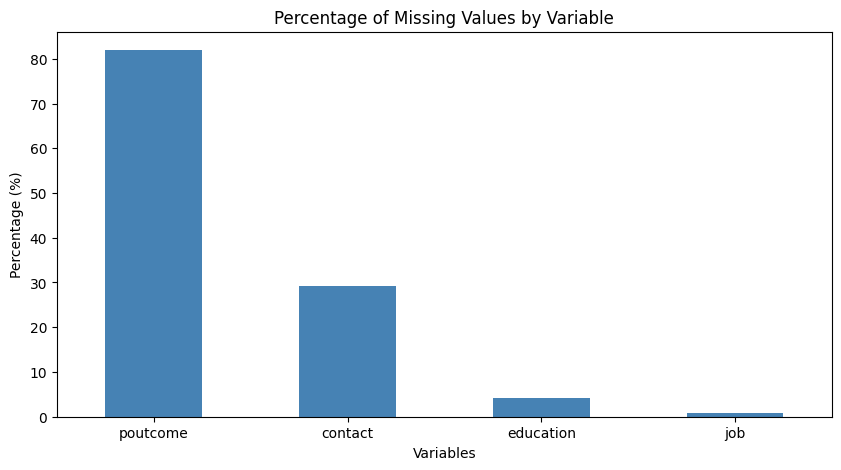

In [8]:
# missing values percentage 
missing_pct[missing_pct > 0].sort_values(ascending=False).plot(kind='bar', 
                                                               figsize=(10, 5), 
                                                               color='steelblue')
plt.title('Percentage of Missing Values by Variable')
plt.ylabel('Percentage (%)')
plt.xlabel('Variables')
plt.xticks(rotation=0)
plt.show()

### **Imputation**

In this section, we will conduct a brief exploratory data analysis for each variable containing missing values. The primary goal of this initial EDA is to select and justify the most appropriate imputation strategy for each variable.

***'job' variable***

Quick EDA on 'job' variable to determine imputation method consists of two parts. First, we check if there is any particular pattern or correlation between job type missingness and education level. Then we check the most common job type.

--- Proportion of Education Levels by Missing Job Info ---

education    primary  secondary  tertiary
job_missing                              
False          15.56      53.31     31.13
True           30.43      34.78     34.78



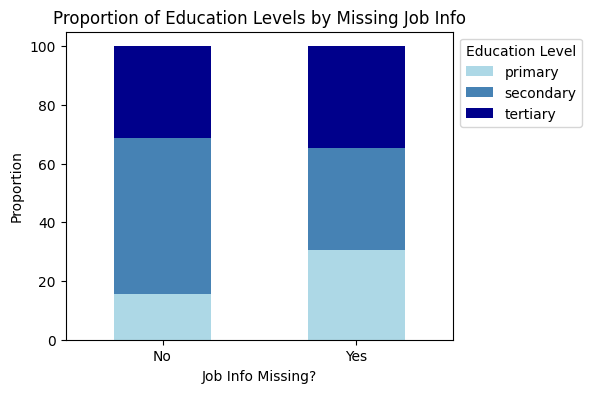

In [9]:
# investigate education level of observations with missing values under 'job' variable 
df['job_missing'] = df['job'].isnull()
props = df.groupby('job_missing')['education'].value_counts(normalize=True).unstack()*100
print("--- Proportion of Education Levels by Missing Job Info ---\n")
print(f"{props.round(2)}\n")
props.plot(kind='bar', 
           stacked=True, 
           color=['lightblue','steelblue','darkblue'],
           figsize=(5, 4))
plt.title('Proportion of Education Levels by Missing Job Info')
plt.xlabel('Job Info Missing?')
plt.ylabel('Proportion')
plt.xticks([0,1],['No','Yes'], rotation=0)
plt.legend(title='Education Level', bbox_to_anchor=(1, 1))
plt.show()

Clients with missing job information are slightly more likey to have a tertiary education while having less secondary education. Despite this minor difference, the extremely small number of missing values (0.84%) makes a simple **mode imputation** the most practical and defensible choice.

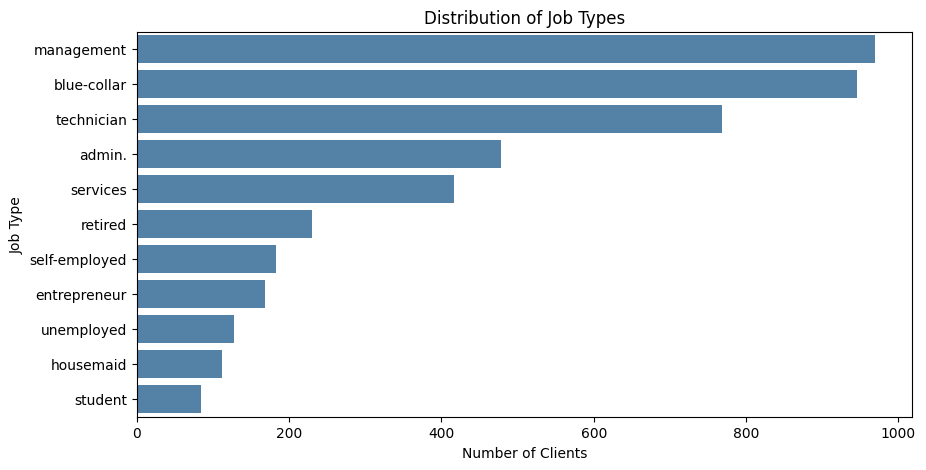

In [10]:
# 'job' variable horizontal bar plot
plt.figure(figsize=(10,5))
sns.countplot(y='job', 
              data=df, 
              order=df['job'].value_counts().index, 
              color='steelblue')
plt.title('Distribution of Job Types')
plt.xlabel('Number of Clients')
plt.ylabel('Job Type')
plt.show()

In [11]:
# 'job' variable - mode imputation
job_mode = df['job'].mode()[0]
df['job'] = df['job'].fillna(job_mode)
print(f"Total missing 'job' values after imputation: {df['job'].isnull().sum()}")
print(f"Missing 'job' values filled with mode: {job_mode}\n")

Total missing 'job' values after imputation: 0
Missing 'job' values filled with mode: management



***'education' variable***

Quick EDA on 'education' variable with hypothesis that person's education level is related to his/her job type. We create a normalized stacked bar chart to validate our hypothesis. If each bar has different proportion of colors, it proves a strong association between job type and education level.

--- Proportion of Education Levels by Job Type ---

education      primary  secondary  tertiary
job                                        
admin.            3.69      85.25     11.06
blue-collar      40.77      57.90      1.33
entrepreneur     16.56      36.94     46.50
housemaid        53.27      26.17     20.56
management        4.77      12.85     82.38
retired          37.04      48.61     14.35
self-employed     8.38      42.46     49.16
services          6.19      89.85      3.96
student           2.94      69.12     27.94
technician        2.01      69.71     28.28
unemployed       20.63      53.97     25.40



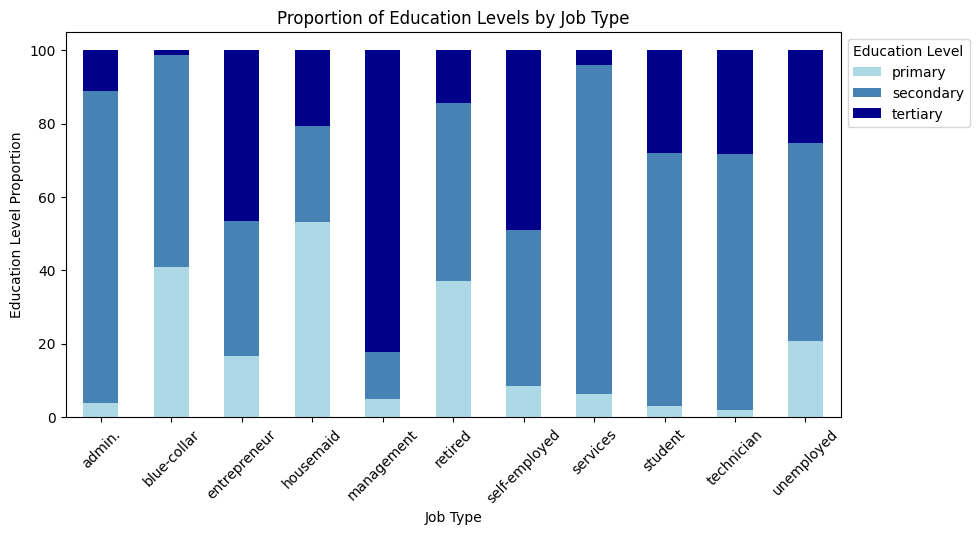

In [12]:
# investigate correlation between 'job' and 'education' variables
props = df.groupby('job')['education'].value_counts(normalize=True).unstack()*100
print("--- Proportion of Education Levels by Job Type ---\n")
print(f"{props.round(2)}\n")
props.plot(kind='bar',
           stacked=True,
           color=['lightblue','steelblue','darkblue'],
           figsize=(10, 5))
plt.title('Proportion of Education Levels by Job Type')
plt.xlabel('Job Type')
plt.ylabel('Education Level Proportion')
plt.xticks(rotation=45)
plt.legend(title='Education Level', bbox_to_anchor=(1, 1))
plt.show()

'entrepreneur', 'management', and 'self-employed' jobs are dominated by clients with tertiary education while 'blue-collar' and 'services' jobs are overwhelmingly composed of clients with secondary education. Each bar has a unique color pattern, proving that client's job gives a strong clue about their likely education level. Therefore, **missing education values will be assigned the most common education values within each job type.**

In [13]:
# 'education' variable - conditional mode imputation based on 'job'
edu_mode = df.groupby('job')['education'].apply(lambda x: x.mode()[0])
print("--- Education Mode by Job Type ---\n")
print(edu_mode)

--- Education Mode by Job Type ---

job
admin.           secondary
blue-collar      secondary
entrepreneur      tertiary
housemaid          primary
management        tertiary
retired          secondary
self-employed     tertiary
services         secondary
student          secondary
technician       secondary
unemployed       secondary
Name: education, dtype: object


In [14]:
job_edu_df = edu_mode.reset_index()
job_edu_df.columns = ['job', 'education_mode']
merged_df = pd.merge(df, job_edu_df, on='job', how='left')
merged_df['education'] = merged_df['education'].fillna(merged_df['education_mode'])
merged_df = merged_df.drop(columns=['education_mode'])
print(f"Total missing 'education' values after imputation: {merged_df['education'].isnull().sum()}")
print(f"Missing 'education' values filled based on each job's education mode.\n")

# delete temporary column
df = merged_df
del df['job_missing']


Total missing 'education' values after imputation: 0
Missing 'education' values filled based on each job's education mode.



***'contact' variable***

'Contact' variable has 29.3% missing values which is too high for a simple imputation. We check if the missing values in the 'contact' variable hold any meaning by formulating the hypothesis that the subscription success rate for clients with a missing contact type is different from the rates for clients with other contact types. If a group with missing values shows different success rate from other contact types, we will **treat missings values as a distinct contact type.**

--- Subscription Success Rate by Contact Type ---

y             no    yes
contact                
telephone  85.38  14.62
cellular   85.64  14.36
missing    95.39   4.61



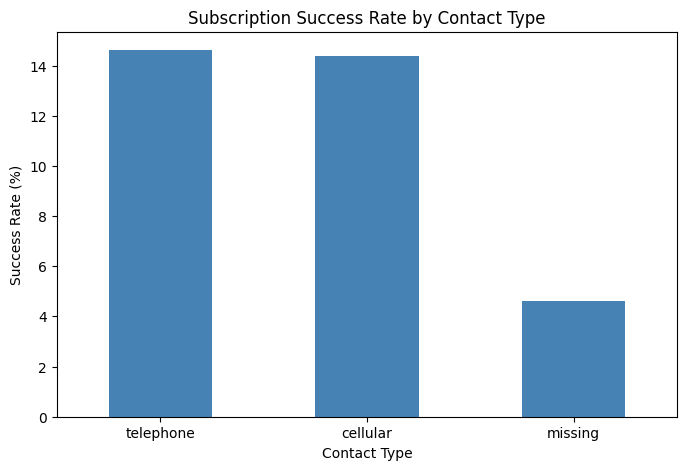

In [15]:
# investigate subscription success rate by 'contact' type
temp_df = df.copy()
temp_df['contact'] = temp_df['contact'].fillna('missing')
contact_success = temp_df.groupby('contact')['y'].value_counts(normalize=True).unstack().sort_values(by='yes', ascending=False)*100
print("--- Subscription Success Rate by Contact Type ---\n")
print(f"{contact_success.round(2)}\n")

contact_success['yes'].plot(kind='bar',
                            figsize=(8,5),
                            color='steelblue')
plt.title('Subscription Success Rate by Contact Type')
plt.xlabel('Contact Type')
plt.ylabel('Success Rate (%)')
plt.xticks(rotation=0)
plt.show()

There is a noticeable difference in the subscription success rate between the two known contact types and the group where contact information was not recorded. This confirms that clients with an unknown contact type behaves differently, validating the strategy of treating these values as a distinct third contact type, which will be label **'unspecified.'**

In [16]:
# 'contact' variable - fill with 'unspecified'
df['contact'] = df['contact'].fillna('unspecified')
print(f"Total missing 'contact' values after imputation: {df['contact'].isnull().sum()}")
print(f"Final contact types: {df['contact'].unique()}\n")

Total missing 'contact' values after imputation: 0
Final contact types: ['cellular' 'unspecified' 'telephone']



*'poutcome' variable*

The 'poutcome' variable, which describes the result of the previous marketing campaign, is categorized as 'unknown' for over 80% of clients. We hypothesize that this is not a random data error. Instead, we believe this large group will have a fundamentally different subscription behavior than those with a known outcome (success, failure, or other). Our EDA will test this hypothesis to validate **treating this 'unknown outcome' group as a distinct category.**

--- Subscription Success Rate by Previous Campaign Outcome ---

y            no    yes
poutcome              
success   35.66  64.34
other     80.71  19.29
failure   87.14  12.86
missing   90.90   9.10



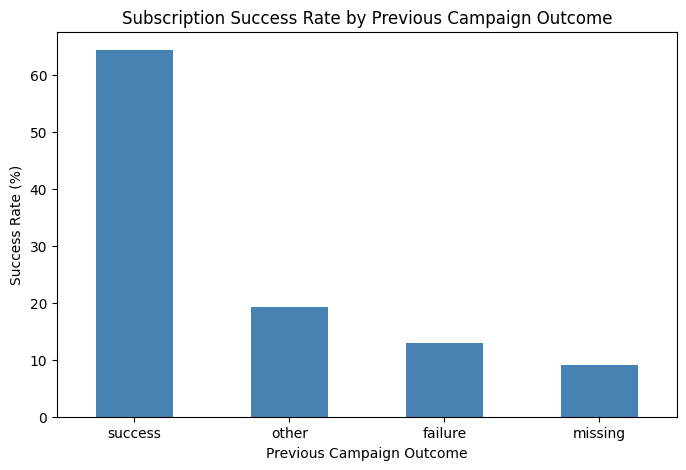

In [17]:
# investigate success rate by exposure to previous campaign
temp_df = df.copy()
temp_df['poutcome'] = temp_df['poutcome'].fillna('missing')
success_rate = temp_df.groupby('poutcome')['y'].value_counts(normalize=True).unstack().sort_values(by='yes', ascending=False)*100
print("--- Subscription Success Rate by Previous Campaign Outcome ---\n")
print(f"{(success_rate).round(2)}\n")

success_rate['yes'].plot(kind='bar',
                         figsize=(8,5),
                         color='steelblue')
plt.title('Subscription Success Rate by Previous Campaign Outcome')
plt.xlabel('Previous Campaign Outcome')
plt.ylabel('Success Rate (%)')
plt.xticks(rotation=0)
plt.show()

Over 60% of clients with a previous 'success' subscribed again, making past success a powerful predictor. Furthermore, the 'missing' group has a distinct success rate of about 9.10%, different from the other known categories. It confirms our hypothesis that this group exhibits unique behavior. Therefore, we will treat 'missing' group as a fourth category and label it as **'unknown_outcome'.**

In [18]:
# 'poutcome' variable - fill with 'unknown_outcome'
df['poutcome'] = df['poutcome'].fillna('unknown_outcome')
print("--- Final Missing Values Check ---\n")
print(f"Total missing 'contact' values after imputation: {df['poutcome'].isnull().sum()}")
print(f"Final poutcome types: {df['poutcome'].unique()}\n")

--- Final Missing Values Check ---

Total missing 'contact' values after imputation: 0
Final poutcome types: ['unknown_outcome' 'failure' 'other' 'success']



**Imputation Conclusion**

In [19]:
# final imputation check
print("--- Final Missing Values Check ---\n")
print(df.isnull().sum())

--- Final Missing Values Check ---

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


At the end of this imputation process, the dataset is 100% free of missing values. All cleaning decisions were justified using specified exploratory data analysis. 
- 'job' variable: simple mode imputation
- 'education' variable: most common education level within the same job type
- 'contact' variable: turn missing values group into a new distinct category, 'unspecified'
- 'poutcome' variable: turn missing values group into a new distinct category, 'unknown_outcome'

The data is now ready for the main EDA phase.

### **Exploratory Data Analysis (EDA)**

The objective of our EDA is to determine if demographic profiles and past campaign experience are key drivers of customer behavior and to derive business trade-off analysis.

This EDA will be a two-part investigation focusing on:
- **Finding the stongest predictors:** This part will be used to validate the hypothesis that demographic profiles (age, job, and financial stability) and campaign interactions influence customer subscription behavior.

- **Setting the stage for the business trade-off:** This part will be used to understand the baseline of a successful subscription.

#### **Part 1: Finding the Strongest Predictors**

***Age Distribution: subscribers vs. non-subscribers***

To identify if there is a noticeable difference depending on age, we generate a kernel density plot to analyze the age distribution of customers who accepted the offer versus those who did not. 

--- Age Statistics by Subscription Outcome ---

      count       mean        std   min   25%   50%   75%   max
y                                                              
no   4000.0  40.998000  10.188398  19.0  33.0  39.0  48.0  86.0
yes   521.0  42.491363  13.115772  19.0  32.0  40.0  50.0  87.0



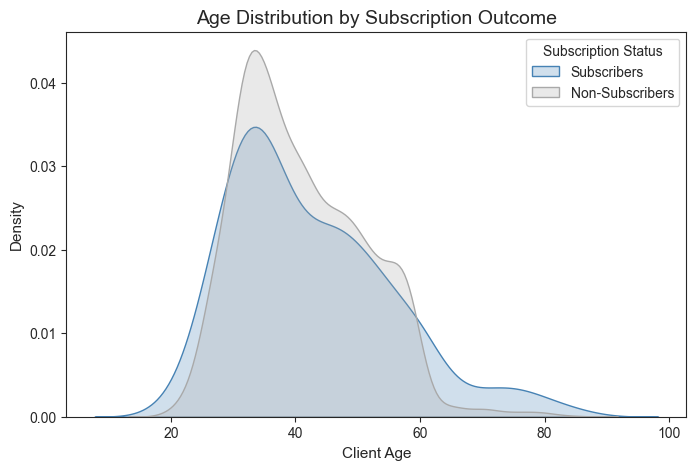

In [20]:
# age distribution by subscription outcome
age_stats = df.groupby('y')['age'].describe()
print("--- Age Statistics by Subscription Outcome ---\n")
print(f"{age_stats}\n")

# kernel density plot of age distribution by subscription outcome
age_y_df = df[['age', 'y']].copy()
yes_group = age_y_df[age_y_df['y']=='yes']
no_group = age_y_df[age_y_df['y']=='no']

sns.set_style("ticks")
plt.figure(figsize=(8,5))

sns.kdeplot(data=yes_group,
            x='age',
            fill=True,
            label='Subscribers',
            color='steelblue')
sns.kdeplot(data=no_group, 
            x='age', 
            fill=True,
            label='Non-Subscribers',
            color='darkgray')

plt.title('Age Distribution by Subscription Outcome', fontsize=14)
plt.xlabel('Client Age', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.legend(title='Subscription Status')
plt.show()


The age distribution of clients who subscribed is different from those who did not. While the non-subscriber group is concentrated among client aged between 30 - 50, the subscriber group shows higher concentrations before age 30 and after age 60. This insight can help the bank navigating its targeted marketing to specific age demographics.

***Subscription Rate by Job Types***

To test if different profession type affect subscription rate, we create a simple horizontal bar plot with rate per job type.

--- Subscription Rate by Job Type ---

y                 no    yes
job                        
retired        76.52  23.48
student        77.38  22.62
management     86.30  13.70
housemaid      87.50  12.50
admin.         87.87  12.13
self-employed  89.07  10.93
technician     89.19  10.81
unemployed     89.84  10.16
services       90.89   9.11
entrepreneur   91.07   8.93
blue-collar    92.71   7.29



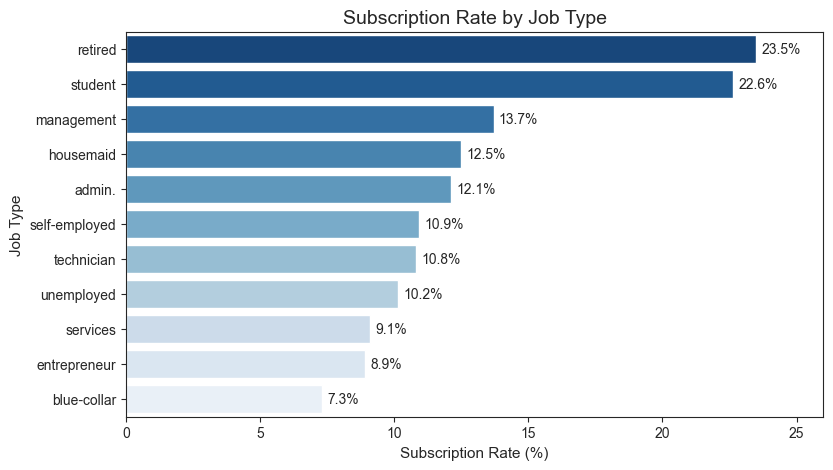

In [21]:
# subscription rate by job type
sub_rate_job = df.groupby('job')['y'].value_counts(normalize=True).unstack().sort_values(by='yes', ascending=False)*100
print("--- Subscription Rate by Job Type ---\n")
print(f"{sub_rate_job.round(2)}\n")

sns.set_style("ticks")
plt.figure(figsize=(9,5))
ax = sns.barplot(x=sub_rate_job['yes'],
                 y=sub_rate_job.index,
                 hue=sub_rate_job.index,
                 palette='Blues_r')

for p in ax.patches:
    width = p.get_width()
    plt.text(width + .2, 
             p.get_y() + p.get_height() / 2, 
             f'{width:.1f}%', 
             va='center')
    
plt.title('Subscription Rate by Job Type', fontsize=14)
plt.xlabel('Subscription Rate (%)', fontsize=11)
plt.ylabel('Job Type', fontsize=11)
plt.xlim(0, 26)
plt.show()

--- Average Subscription Rate: Top Groups vs Others ---

                           Group  Average Subscription Rate (%)
0  Top Groups (Retired, Student)                          23.05
1                Other Job Types                          10.62



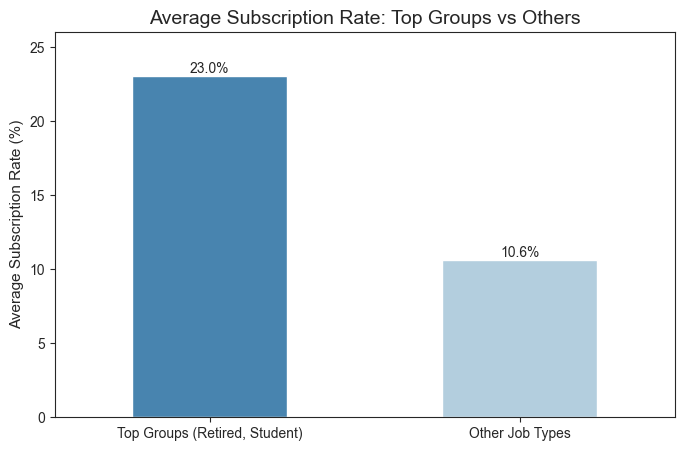

In [22]:
# average subscription rate of top two job types vs others
top_groups = ['retired', 'student']
avg_topGroup = sub_rate_job.loc[top_groups, 'yes'].mean()
avg_others = sub_rate_job.drop(top_groups).loc[:, 'yes'].mean()

temp_df = pd.DataFrame({
    'Group': ['Top Groups (Retired, Student)', 'Other Job Types'],
    'Average Subscription Rate (%)': [avg_topGroup, avg_others]
})
print("--- Average Subscription Rate: Top Groups vs Others ---\n")
print(f"{temp_df.round(2)}\n")

sns.set_style("ticks")
plt.figure(figsize=(8,5))
ax = sns.barplot(x='Group',
                 y='Average Subscription Rate (%)',
                 data=temp_df,
                 hue='Group',
                 legend=False,
                 palette='Blues_r',
                 width=.5)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', 
                va='bottom')
plt.title('Average Subscription Rate: Top Groups vs Others', fontsize=14)
plt.ylim(0, 26)
plt.ylabel('Average Subscription Rate (%)', fontsize=11)
plt.xlabel('')
plt.show()

The analysis reveals that a client's profession is a strong indicator of their likelihood to subscribe. 'Retired' clients (23.0%) and 'students' (22.6%) are the two most receptive groups. A direct comparison shows that, on average, these top two groups are more than twice as likely to subscribe as all other professions combined. This data suggests that the marketing efforts should be segmented and prioritized, with a multi-tiered marketing strategies specifically designed for each group.
- High-priority segments: This group should receive the most personalized and focused marketing efforts to maximize the outcome.

- Mid-priority segments: This group, while less likely to subscribe compared to the top group, still represents a significant pool of potential customers. This segment could be targeted with more cost-effecitve, standarized marketing campaign.

- Low-priority segments: For the least receptive group, marketing resources can be de-prioritized to improve overall campaign's return on investment by minimizing spending.

This data-driven segmentation allows the bank to allocate its marketing budget more effectively across the entire customer spectrum.

***Marital Status on Subscription Rate***

We hypothesize that an individual's marital status may influence their financial decisions, including whether to open a term deposit. To test this, we will analyze and compare the subscription rates for each category: 'single', 'married', and 'divorced.'

--- Subscription Rate by Marital Status ---

y            no    yes
marital               
divorced  85.42  14.58
single    86.04  13.96
married   90.10   9.90



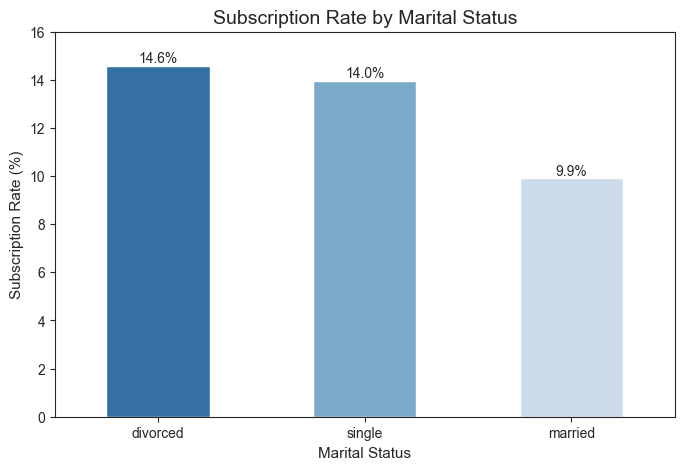

In [23]:
# subscription rate by marital status
marital_df = df.groupby('marital')['y'].value_counts(normalize=True).unstack()*100
marital_df = marital_df.sort_values(by='yes', ascending=False)

print("--- Subscription Rate by Marital Status ---\n")
print(f"{marital_df.round(2)}\n")

sns.set_style("ticks")
plt.figure(figsize=(8,5))
ax = sns.barplot(x=marital_df.index,
                 y=marital_df['yes'],
                 hue=marital_df.index,
                 legend=False,
                 palette='Blues_r',
                 width=.5)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', 
                va='bottom')
plt.title('Subscription Rate by Marital Status', fontsize=14)
plt.ylim(0, 16)
plt.ylabel('Subscription Rate (%)', fontsize=11)
plt.xlabel('Marital Status', fontsize=11)
plt.show()

The analysis of marital status reveals a distinct pattern in subscription behavior. Two segments show a significantly higher propensity to subscribe:
- **Divorced:** 14.6%

- **Single:** 14.0%

In contrast, 'married' clients have a lower subscription rate (9.90%). This suggests that marketing strategies can be tailored to emphasize financial independence and savings goals for these non-married segments.

***Financial Indicators***

To understand the financial profile of the customers and to see how it is correlated to subscription rate, this analysis explores four variables: 'default', 'balance', 'housing', and 'loan.' These are grouped as follows:

- **Binary indicators:** default, housing, loan

- **Continuous variable:** balance

***Binary Indicators***

This section examines how a client's financial history impacts their propensity to subscribe. We will compare the subscription rates for clients based on three binary indicators:
- Do they have a housing loan?

- Do they have a personal loan?

- Do they have a history of credit default?


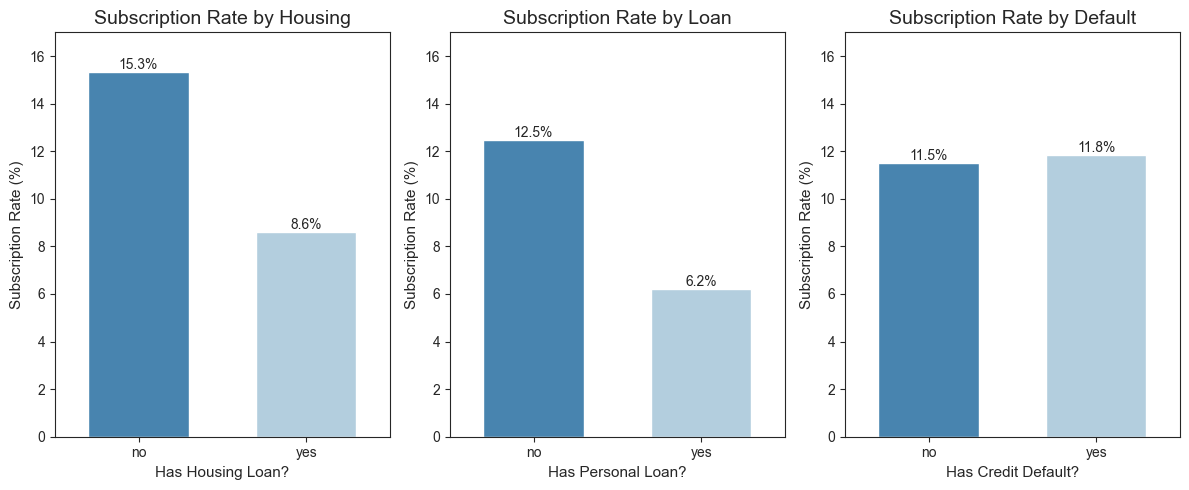

In [24]:
# binary indicators
binary_vars = ['housing', 'loan', 'default']
x_labels = ['Has Housing Loan?', 'Has Personal Loan?', 'Has Credit Default?']
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.set_style("ticks")

for i, col in enumerate(binary_vars):
    rate = df.groupby(col)['y'].value_counts(normalize=True).unstack()['yes']*100
    sns.barplot(x=rate.index,
                y=rate.values,
                hue=rate.index,
                legend=False,
                ax=axes[i],
                palette='Blues_r',
                width=.6)
    
    axes[i].set_title(f'Subscription Rate by {col.capitalize()}', fontsize=14)
    axes[i].set_ylabel('Subscription Rate (%)', fontsize=11)
    axes[i].set_xlabel(x_labels[i], fontsize=11)
    axes[i].set_ylim(0, 17)

    for p in axes[i].patches:
        height = p.get_height()
        axes[i].annotate(f'{height:.1f}%', 
                         (p.get_x() + p.get_width() / 2, height), 
                         ha='center', 
                         va='bottom')

plt.tight_layout()
plt.show()

The analysis of key financial indicators reveals that a client's existing debt obligations are a major factor in their decision to subscribe. **Clients without a housing loan or a personal loan are approximately twice as likely to open a term deposit** compared to those who have these loans. This suggests that customers with more disposable income or fewer financial commitment represent a high-potential segment for targeted marketing. In contrast, a client's credit default status appears to have no significant impact on their subscription likelihood.

***Continuous Variable***

Moving from the binary financial indicators, this section analyzes the continuous financial variable: account balance. While the previous indicators described a client's financial obligations, the 'balance' variable offers insight into their financial capacity. We will investigate how this variable correlates with the subscription rate.

--- Balance Statistics by Subscription Outcome ---

      count         mean          std     min    25%    50%     75%      max
y                                                                           
no   4000.0  1403.211750  3075.349313 -3313.0   61.0  419.5  1407.0  71188.0
yes   521.0  1571.955854  2444.398956 -1206.0  171.0  710.0  2160.0  26965.0



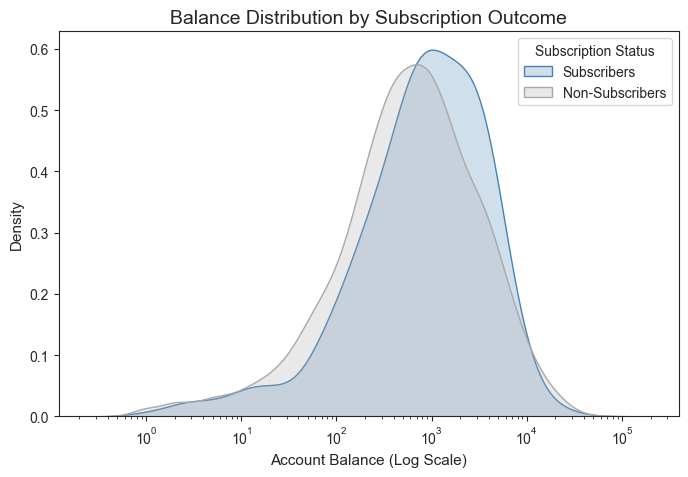

In [25]:
# continuous variable
balance_stats = df.groupby('y')['balance'].describe()
print("--- Balance Statistics by Subscription Outcome ---\n")
print(f"{balance_stats}\n")

# only keep positive balance values to apply log transformation
pos_balance_df = df[df['balance'] > 0].copy()

sns.set_style("ticks")
plt.figure(figsize=(8,5))
sns.kdeplot(data=pos_balance_df,
            x='balance',
            hue='y',
            fill=True,
            common_norm=False,
            palette=['darkgray', 'steelblue'],
            log_scale=True)

plt.title('Balance Distribution by Subscription Outcome', fontsize=14)
plt.xlabel('Account Balance (Log Scale)', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.legend(title='Subscription Status', labels = ['Subscribers', 'Non-Subscribers'])
plt.show()

The account balance distribution is heavily right-skewed. After applying a log transform to visualize the underlying pattern, it becomes clear that **clients who subscribe to the term deposite tend to have a higher account balance** than those who do not. The peak of the subscriber distribution is centered at a higher balance, which is supported by summary statistics showing higher mean balance for the subscriber group. This suggests that clients with more funds are a key demographic for this savings product.

***Past & Current Campaign Effectiveness***

To test how campaing experience influences customer subsrciption rate, we analyze campaign related variables: previous, 'previous', 'pdays', 'campaign', and 'duration.' These are categorized as follows:

- **Past campaign variables:** previous, pdays

- **Current campaign variables:** campaign, duration

***Previous Campaign Exposures on Subscription Rate***

We believe there is a positive correlation between past campaign exposure and propensity to subscribe. To validate this hypothesis, we will group customers by the number of contacts they received and analyze the corresponding subscription rate for each segment to identify any positive trends. 

--- Previous Campaign Exposures Statistics ---

previous
Never Contacted:     3705
Contacted Before:     816
Name: count, dtype: int64

--- Subscription Rate by Previous Campaign Exposures ---

previous_binned
0      9.10
1     17.83
2     25.91
3+    24.63
Name: yes, dtype: float64



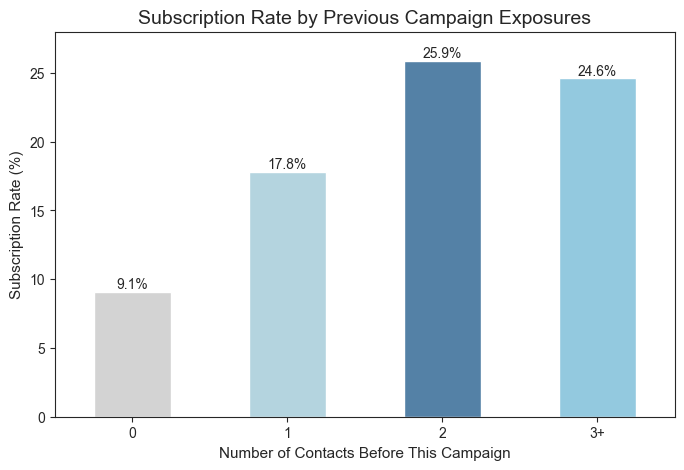

In [26]:
# number of previous campaign exposures on subscription outcome - previous
print("--- Previous Campaign Exposures Statistics ---\n")
contacted = (df['previous'] > 0).value_counts()
contacted = contacted.rename(index={True: 'Contacted Before:', False: 'Never Contacted:'})
print(f"{contacted}\n")

temp_df = df.copy()
bins = [0, 1, 2, 3, float('inf')]
labels = ['0', '1', '2', '3+']
temp_df['previous_binned'] = pd.cut(temp_df['previous'], bins=bins, labels=labels, right=False)

prev_rate = temp_df.groupby('previous_binned', observed=True)['y'].value_counts(normalize=True).unstack()['yes']*100
print("--- Subscription Rate by Previous Campaign Exposures ---\n")
print(f"{prev_rate.round(2)}\n")

sns.set_style("ticks")
plt.figure(figsize=(8,5))
ax = sns.barplot(x=prev_rate.index,
                 y=prev_rate.values,
                 hue=prev_rate.index,
                 legend=False,
                 palette=['lightgray','lightblue','steelblue','skyblue'],
                 width=.5)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%',
                (p.get_x() + p.get_width() / 2, height),
                ha='center',
                va='bottom')

plt.title('Subscription Rate by Previous Campaign Exposures', fontsize=14)
plt.ylim(0, 28)
plt.ylabel('Subscription Rate (%)', fontsize=11)
plt.xlabel('Number of Contacts Before This Campaign', fontsize=11)
plt.show()

The analysis of previous campaign contacts shows a clear positive trend. Clients who have been contacted before are significantly more likely to subscribe than new leads (9.1% success rate). The success rate peaks for clients who have been contacted twice in the past (25.9%), suggesting that previously engaged customers are a high-value target for the next campaigns. 

***Recency of Last Contact on Subscription Rate***

We previously examined the 'poutcome' variable, which describes the outcome of the previous marketing campaign. Before analyzing how 'pdays' (number of days since last contact) influences subscription rate, it is important to first examine its relationship with 'pcoutcome.' 

This is because 'pdays' variable uses a special value of **-1** to signify clients who were not previously contacted. By confirming that this group directly corresponds to the 'unknown_outcome' group from 'poutcome' variable, we can avoid redundant analysis. This allows us to focus our EDA on the clients who were previously contacted to answer a new, more specified question: **does the recency of past contact affect the subscription rate?**

In [27]:
# check relationship between outcome of previous marketing campaign and number of days since last contact
print("--- Relationship between (pdays == -1) and poutcome ---\n")
print(pd.crosstab(df['pdays'] == -1, df['poutcome']))

--- Relationship between (pdays == -1) and poutcome ---

poutcome  failure  other  success  unknown_outcome
pdays                                             
False         490    197      129                0
True            0      0        0             3705


Cross-tabulation confirms that previously not contacted group (value of -1) is a 'new client' group and allows us to focus on analyzing if the recency of past contact matters.

--- Subscription Rate by Recency of Last Contact ---

pdays_binned
0-90       31.82
91-180     25.67
181-270    26.84
271-360    12.50
361+       20.20
Name: yes, dtype: float64



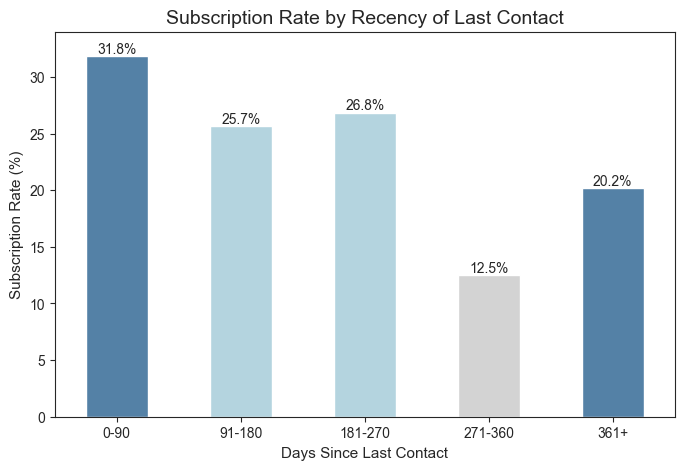

In [28]:
# past days since last contact distribution by subscription outcome
pdays_df = df[df['pdays'] > -1].copy()
bins = [0, 90, 180, 270, 360, float('inf')]
labels = ['0-90', '91-180', '181-270', '271-360', '361+']
pdays_df['pdays_binned'] = pd.cut(pdays_df['pdays'], bins=bins, labels=labels, right=False)
pdays_rate = pdays_df.groupby('pdays_binned', observed=True)['y'].value_counts(normalize=True).unstack()['yes']*100
print("--- Subscription Rate by Recency of Last Contact ---\n")
print(f"{pdays_rate.round(2)}\n")

sns.set_style("ticks")
plt.figure(figsize=(8,5))
ax = sns.barplot(x=pdays_rate.index,
                 y=pdays_rate.values,
                 hue=pdays_rate.index,
                 legend=False,
                 palette=['steelblue','lightblue','lightblue','lightgray','steelblue'],
                 width=.5)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.1f}%",
                (p.get_x() + p.get_width() / 2, height),
                ha='center',
                va='bottom')

plt.title("Subscription Rate by Recency of Last Contact", fontsize=14)
plt.xlabel("Days Since Last Contact", fontsize=11)
plt.ylabel("Subscription Rate (%)", fontsize=11)
plt.ylim(0,34)
plt.show()


The analysis of 'pdays' reveals two key strategic insights:
- **Recency is a powerful factor:** Clients contacted within the last 90 days have the highest subscription rate at 31.8%

- **Annual follow-up matters:** Those contacted over a year ago also show a strong propensity to subscribe at 20.2%, a rate notably higher than the previous segment (271 - 360 days)

This suggests that a dual approach could be highly effective: 
- **Targeting recently contacted individuals** 

- **Implementing an annual follow-up campaign for older contacts**

***Number of Contacts on Subscription Rate***

To understand campaign effectiveness, we will analyze the relationship between the number of contacts and the subscription rate. While this feature introduces **data leakage** and would be unsuitable for a predictive model, this analysis is crucial for identifying the point of diminishing returns in the outreach strategy.

***Contact Duration on Subscription Rate***

***Seasonality***

#### **Part 2: Setting the Stage for the Business Trade-off**

***Target Variable Counts***

The following analysis will reveal which statistical metrics should be used to determine an optimal approach to a data-driven strategy

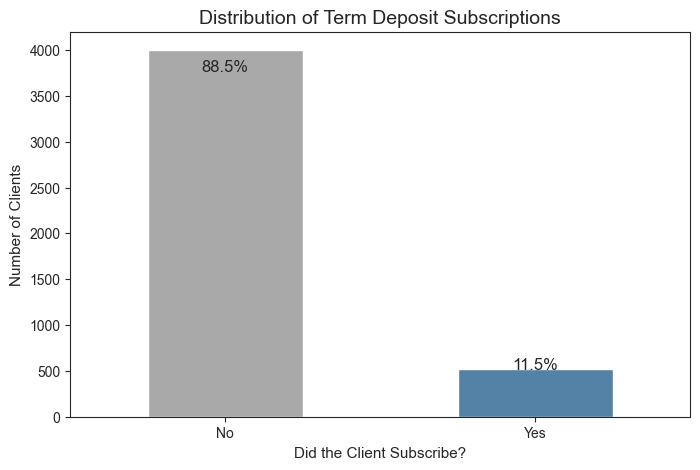

In [29]:
# target variable distribution
sns.set_style('ticks')
plt.figure(figsize=(8,5))
ax = sns.countplot(x='y', 
                   data=df, 
                   order=df['y'].value_counts().index, 
                   hue='y',
                   legend=False,
                   palette=['darkgray','steelblue'],
                   width=0.5)

total = len(df['y'])
for p in ax.patches:
    pct = f"{100 * p.get_height()/total:.1f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_x() + p.get_height() / 1.07
    ax.annotate(pct, (x, y), ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Term Deposit Subscriptions', fontsize=14)
plt.xlabel('Did the Client Subscribe?', fontsize=11)
plt.ylabel('Number of Clients', fontsize=11)
plt.xticks([0,1], ['No', 'Yes'])
plt.show()

The distribution of the target variable reveals a significant class imbalance. This confirms that successful subscriptions are a rare event, making a targeted marketing approach essential. Due to this imbalance, accuracy will be a misleading metric for model evaluation. Our analysis needs to focus on the trade-off between **precision (minimizing wasted effort)** and **recall (minizing missed opportunities)** to derive an optimal, data-driven marketing strategy.

**Source Citation**

Moro, S., Laureano, R. and Cortez, P. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), 

Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.